# Q-Table & Policy Gradients

In [2]:
# General imports
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm


# Create graphs folder
Path("graphs/").mkdir(exist_ok=True)

### Frozen Lake environment

- The Frozen Lake environment is a discrete 4×4 grid with four different kinds of grid cells:
        * S: starting point
        * F: frozen surface 
        * H: hole
        * G: goal

- The goal is to reach the goal from the starting point while avoiding unsafe places. 
- The agent moves around the grid until it reaches the goal (G) or a hole (H). 
- The agent receives a reward of 1 if it reaches the goal and 0 otherwise.


In [3]:
import gym
env = gym.make('FrozenLake-v0')

# TODO Render initial state
env.render()


SFFF
FHFH
FFFH
HFFG


### Manual Navigation

Find action sequence that leads to the goal

In [4]:
from gym.envs.toy_text.frozen_lake import LEFT, DOWN, RIGHT, UP  # Import action constants

# Reset frozenlake env to reproducible state
env.seed(42)
env.reset()
env.render('human')

env.step(RIGHT)
env.step(DOWN)
env.step(DOWN)
env.step(DOWN)
env.step(LEFT)
env.step(UP)
env.render()
env.s


SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG


15

In [5]:
# Test Code
np.testing.assert_equal(env.s, 15, err_msg="Env not in goal state")
"ok"

'ok'

### Building the Q-Table
The update rule:

<img src="./photos/Q-table_update.png" width="500">

where $\alpha$ is the learn rate, and $\gamma$ 
 is the discount factor for future returns

Training:   0%|          | 0/2000 [00:00<?, ?it/s]

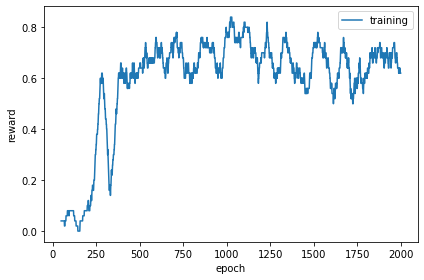

In [6]:
# Initialize Q-table of size 16x4
Q = np.zeros([env.observation_space.n, env.action_space.n])

# Hyperparameters
lr = 0.8
gamma = 0.95
num_episodes = 2000
max_steps_per_episode = 100

# Create lists to contain total rewards and steps per episode
rewards = np.zeros(num_episodes)

for i in tqdm(range(num_episodes), desc="Training"):
    # Reset environment and observe initial state
    s = env.reset()

    # The Q-Table learning algorithm
    for _ in range(max_steps_per_episode):

        a = np.argmax(Q[s, :] + np.random.randn(1, env.action_space.n) * (1. / (i + 1)))

        # Get new state and reward from environment
        s_new, r, done, _ = env.step(a)

        Q[s, a] = Q[s, a] + lr * (r + gamma * np.max(Q[s_new, :]) - Q[s, a])

        # Bookkeeping
        rewards[i] += r
        s = s_new

        if done:  # Check if episode terminated
            break

# Plot rewards
sns.lineplot(data=pd.DataFrame(rewards, columns=["training"]).rolling(50).mean())
plt.xlabel("epoch")
plt.ylabel("reward")
plt.tight_layout()
plt.savefig("graphs/a1c-train.png")

### Plot Q-table

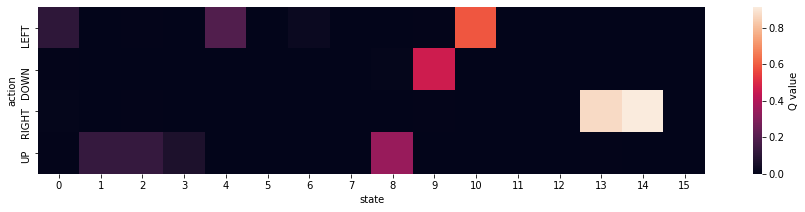

In [7]:
plt.figure(figsize=(14, 3))
sns.heatmap(Q.T, square=True, cbar_kws={'label': 'Q value'},yticklabels=["LEFT", "DOWN", "RIGHT", "UP"])
plt.xlabel("state")
plt.ylabel("action")
plt.tight_layout()
plt.savefig("graphs/a1c-q-values.png")

### Test Code

In [8]:
def rollout(env, Q, seed=None):
    """Perform single rollout"""
    reward = 0
    env.seed(seed)
    s = env.reset()
    for _ in range(max_steps_per_episode):
        # Choose action greedily from Q-table
        a = np.argmax(Q[s, :])
        s, r, done, _ = env.step(a)
        reward += r
        if done:  # Check if episode terminated
            break
    return reward

validation_reward = np.mean([rollout(env, Q, i) for i in range(100)])
print(f"Validation reward: {validation_reward}", )
assert validation_reward > 0.5, f"Average reward of learned Q-table should be greater than 0.5"
"ok"

Validation reward: 0.66


'ok'

## Policy Gradients

In [9]:
# Imports
import gym 
import torch
import torch.nn as nn
import torch.nn.functional as F
 

### CartPole environment

- The CartPole environment consists of a pole that is attached by an un-actuated joint to a cart that moves along a frictionless track.  
- The pendulum starts upright and the goal is to keep the pole upright and prevent it from falling over by increasing or reducing the cart’s velocity.


**Observations**:

<img src="./photos/observation.png" width="500">


**Action space**:

<img src="./photos/action_space.png" width ="250">


In [10]:
# Take a look at the environment
env = gym.make('CartPole-v1')

for _ in range(10):
    state, done = env.reset(), False
    while not done: 
        action = env.action_space.sample() # Random action
        state, _, done, _ = env.step(action)

        env.render()

env.close()

### Defining the Policy

In [11]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        # TODO Create layers
        self.layer_1 = nn.Linear(4,128)
        self.layer_2 = nn.Linear(128,2)
        
    def forward(self, x):
        # TODO Implement forward pass
        x = F.relu(self.layer_1(x))
        x = F.softmax(self.layer_2(x)) 
        return x

In [12]:
# Test code
_test_output = Policy()(torch.tensor([[1.0,2,3,4]]))
assert _test_output.shape == (1, 2), f"Expected output shape (1, 2), got {_test_output.shape}"
np.testing.assert_almost_equal(_test_output.detach().numpy().sum(), 1, err_msg="Output is not a probability distribution.")
"ok"

<ipython-input-11-42f2e6fb076f>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.layer_2(x))


'ok'

### Action Sampling

In [13]:
def sample_action(probs):
    """Sample one action from the action distribution of this state.
    
    Args:
        probs: action probabilities

    Returns:
        action: The sampled action
        log_prob: Logarithm of the probability for sampling that action
    """
    m = torch.distributions.Categorical(probs)
    action = m.sample()
    log_prob = m.log_prob(action)
    action = action.numpy()
    return action, log_prob


In [15]:
# Test code
_test_action, _test_log_prob = sample_action(torch.tensor([1,2,3,4]))
assert _test_action in [0, 1, 2, 3], f"Invalid action {_test_action}"
np.testing.assert_approx_equal(_test_log_prob, np.log((_test_action+1)/10))
"ok"

'ok'

### Estimate Return
Approximate the return of each state by computing the return over each trajectory:

&emsp; &emsp; $R_t$ = $r_t$ + $\gamma$$R_{t+1}$

&emsp; &emsp; where $\gamma$ is the discount factor

In [16]:
def estimate_return(rewards, gamma=0.99):
    returns = []
    a = 0
    for j in range(len(rewards)):
        for i in range(len(rewards)-j):
            a+=rewards[i+j]*(gamma**i)
        returns.append(a)
        a = 0
    returns = (returns - np.mean(returns)) / np.std(returns)
    return returns



In [17]:
# Test code
np.testing.assert_array_almost_equal(
     estimate_return(np.ones(10), gamma=0.99), 
    [1.54572815, 1.21139962, 0.87369404, 0.53257729, 0.18801491,-0.16002789, -0.51158628, -0.86669576, -1.22539221, -1.58771185])
"ok"

'ok'

### Training Loop

  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-11-42f2e6fb076f>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.layer_2(x))


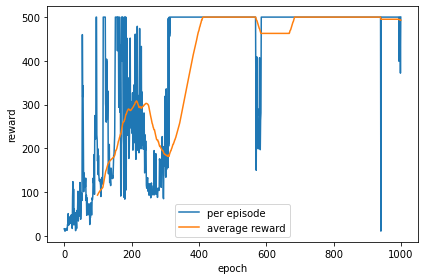

In [27]:
env = gym.make('CartPole-v1')
policy = Policy()

# Hyperparams
episodes = 1000
gamma = 0.99
learn_rate = 1e-2
optimizer = torch.optim.Adam(policy.parameters(), lr=learn_rate)

total_rewards = []
with tqdm(range(episodes)) as pbar:
    for _ in pbar:
        # Run one episode
        log_probs = []
        rewards = []
        state, done = env.reset(), False
        while not done:
            # Take a step
            # Sample action for current state
            state = state.astype(np.float32)
            state = torch.from_numpy(state)
            
            probs = policy(state)  
            action, log_prob = sample_action(probs)
            
            state, reward, done, _ = env.step(action)

            # Bookkeeping
            log_probs.append(log_prob)
            rewards.append(reward)

        total_rewards.append(sum(rewards))

        # Compute loss
        returns = estimate_return(rewards)
        policy_loss = np.sum(-1*np.multiply(log_probs,returns))

        # Update policy
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

         # Print statistics
        pbar.set_description(f"Mean training reward {np.mean(total_rewards[-100:]):.02f}")


# Save model
with open("graphs/a2d.pt", "wb") as f:
    torch.save(policy, f)

# Plot training
plt.plot(total_rewards, label="per episode")
plt.plot(pd.DataFrame(total_rewards).rolling(100).mean(), label="average reward")
plt.xlabel("epoch")
plt.ylabel("reward")
plt.legend()
plt.tight_layout()
plt.savefig("graphs/a2d.png")

In [28]:
# Test code
policy.eval() # Switch to evaluation mode

def _rollout(seed):
    env.seed(seed)
    state, done = env.reset(), False
    while not done:
        probs = policy(torch.tensor(state).float().reshape((1, -1)))[0]
        action = np.argmax(probs.detach().numpy())  # Greedy action
        state, reward, done, _ = env.step(action)
    return env._elapsed_steps
        
_avg_reward = np.mean([_rollout(seed=i) for i in tqdm(range(100), desc="Validating")])
assert _avg_reward >= 487.5, f"Average reward below 487.5, got {_avg_reward}"
f"ok (Average reward {_avg_reward:0.2f})"

Validating:   0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-11-42f2e6fb076f>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.layer_2(x))


'ok (Average reward 500.00)'

In [29]:
# Take a look at the learned policy
greedy = True

policy.eval() # Switch to evaluation mode
state, done = env.reset(), False
while not done: 
    probs = policy(torch.tensor(state).float().reshape((1, -1)))[0]
    if greedy:
        action = np.argmax(probs.detach().numpy())  # Chose optimal action
    else:
        action = sample_action(probs)[0]  # Sample from action distribution
    state, _, done, _ = env.step(action)
    env.render()

env.close()

<ipython-input-11-42f2e6fb076f>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.layer_2(x))
